# This EDA notebook used for basic cleaning of data, not for feauture engineering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv("tour_logs_train.csv")
train_df.head()

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Merch_Sales_Post_Show,Crowd_Energy
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,916,64.96
1,Gig_0001,V_Beta,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,1003,66.42
2,Gig_0002,V_Delta,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,720,42.58
3,Gig_0003,V_Beta,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,Rainy,New Moon,Leather,0,0.00
4,Gig_0004,V_Delta,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,950,67.55


##  EDA for imputing missing/0 values in Volume_Level

- **Zero/NaN values** in `Volume_Level` likely indicate sensor failures
- Dropping all such rows is **impractical**
- Values are **temporarily excluded** only for visualization


In [3]:
vol_eda = train_df.copy()

In [4]:
# Removing unuseful,C_E and C_S where val = 0/Nan since they are highly inconsistent
vol_eda = vol_eda.drop(columns=["Gig_ID", "Merch_Sales_Post_Show"])
vol_eda = vol_eda.drop(vol_eda[(vol_eda["Crowd_Energy"] <= 0) | (vol_eda["Crowd_Energy"].isna())].index)
vol_eda = vol_eda.drop(vol_eda[(vol_eda["Crowd_Size"] <= 0) | (vol_eda["Crowd_Size"].isna())].index)
vol_eda = vol_eda.drop(vol_eda[(vol_eda["Volume_Level"] <= 0) | (vol_eda["Volume_Level"].isna())].index)

In [5]:
vol_eda.count()

Venue_ID         1588
Show_DateTime    1588
Day_of_Week      1588
Volume_Level     1588
Ticket_Price     1588
Crowd_Size       1588
Opener_Rating    1588
Weather          1588
Moon_Phase       1588
Band_Outfit      1588
Crowd_Energy     1588
dtype: int64

In [6]:
vol_eda.groupby("Venue_ID")["Volume_Level"].describe()

,count,mean,std,min,25%,50%,75%,max
Venue_ID,,,,,,,,
V_Alpha,226.0,3.893805,6.544022,1.0,2.0,4.0,5.0,99.0
V_Beta,368.0,6.057065,3.265625,1.0,3.0,6.0,9.0,11.0
V_Delta,527.0,6.313093,6.566614,1.0,3.0,6.0,9.0,99.0
V_Gamma,467.0,6.355460,5.402867,1.0,3.0,6.0,9.0,99.0


#### The above table tells us that the venues has potential outlier (99) which should be treat as 0/NaN.
#### Which can be conformed by below boxplot

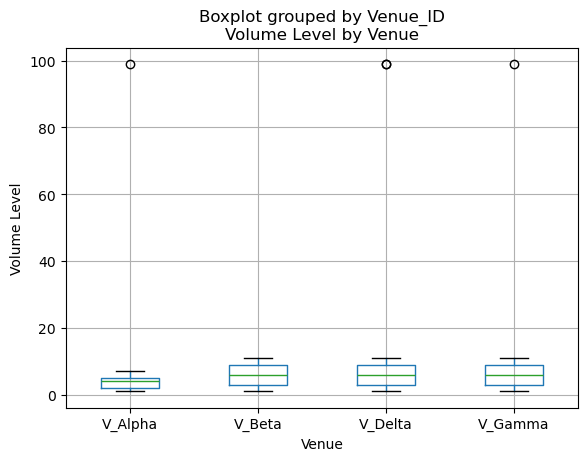

In [7]:
vol_eda.boxplot(column="Volume_Level", by="Venue_ID")
plt.title("Volume Level by Venue")
plt.xlabel("Venue")
plt.ylabel("Volume Level")
plt.show()

#### So, Im dropping these outliers for sound to check again

In [8]:
vol_eda = vol_eda.drop(vol_eda[vol_eda["Volume_Level"] > 20].index)

In [9]:
vol_eda.groupby("Venue_ID")["Volume_Level"].describe()

,count,mean,std,min,25%,50%,75%,max
Venue_ID,,,,,,,,
V_Alpha,225.0,3.471111,1.567047,1.0,2.0,4.0,5.0,7.0
V_Beta,368.0,6.057065,3.265625,1.0,3.0,6.0,9.0,11.0
V_Delta,525.0,5.960000,3.220331,1.0,3.0,6.0,9.0,11.0
V_Gamma,466.0,6.156652,3.279642,1.0,3.0,6.0,9.0,11.0


In [10]:
vol_eda.count()

Venue_ID         1584
Show_DateTime    1584
Day_of_Week      1584
Volume_Level     1584
Ticket_Price     1584
Crowd_Size       1584
Opener_Rating    1584
Weather          1584
Moon_Phase       1584
Band_Outfit      1584
Crowd_Energy     1584
dtype: int64

In [11]:
vol_eda["Volume_Level"].describe()

count    1584.000000
mean        5.686869
std         3.198694
min         1.000000
25%         3.000000
50%         5.000000
75%         9.000000
max        11.000000
Name: Volume_Level, dtype: float64

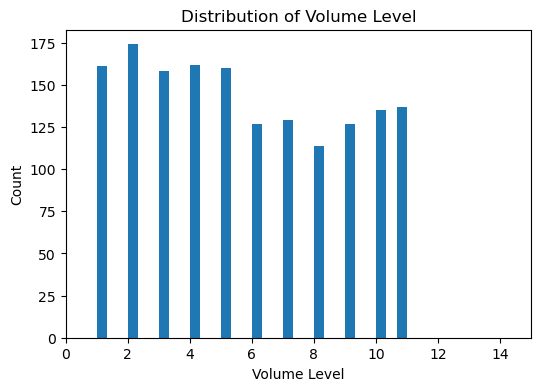

In [12]:
plt.figure(figsize=(6,4))
plt.hist(vol_eda["Volume_Level"], bins=30)
plt.xlim(0, 15)   # zoom into main range
plt.xlabel("Volume Level")
plt.ylabel("Count")
plt.title("Distribution of Volume Level")
plt.show()

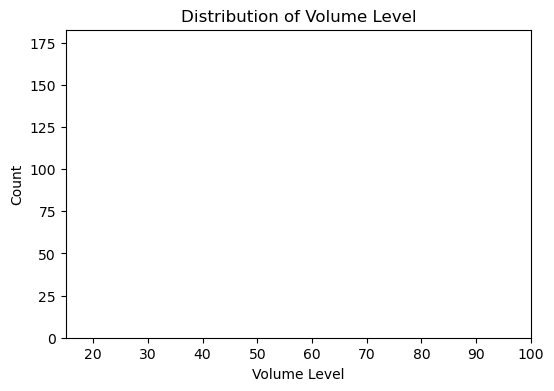

In [13]:
# checking for any other outliers
plt.figure(figsize=(6,4))
plt.hist(vol_eda["Volume_Level"], bins=30)
plt.xlim(15,100)   # zoom into main range
plt.xlabel("Volume Level")
plt.ylabel("Count")
plt.title("Distribution of Volume Level")
plt.show()

#### This shows no other unneccassary value exist

#### So, I conclude that I can impute values where val = 0/Nan and outlier(detected by z-score method)

#### Lets create basic df for further use

In [14]:
df = train_df.copy()

## Note
#### The below code is taken from '*primary_cleaning.py*' which is unfinished by this time 

In [15]:
    df = df.drop(columns=["Gig_ID", "Merch_Sales_Post_Show"])
    df = df.drop(df[(df["Crowd_Energy"] <= 0) | (df["Crowd_Energy"].isna())].index)
    df = df.drop(df[(df["Crowd_Size"] <= 0) | (df["Crowd_Size"].isna())].index)

    # Imputing Volume_Level (Refer EDA_Cleaning.ipynb)
    if "Volume_Level" in df.columns:
        
        df.loc[df["Volume_Level"] <= 0, "Volume_Level"] = None
        df.loc[df["Volume_Level"] >= 20, "Volume_Level"] = None

      # Fill missing values using median
        median_volume = df["Volume_Level"].median()
        df["Volume_Level"] = df["Volume_Level"].fillna(median_volume)

In [16]:
df.count()

Venue_ID         1844
Show_DateTime    1844
Day_of_Week      1844
Volume_Level     1844
Ticket_Price     1844
Crowd_Size       1844
Opener_Rating    1844
Weather          1844
Moon_Phase       1844
Band_Outfit      1844
Crowd_Energy     1844
dtype: int64

## Lets check Crowd_size and its EDA

In [17]:
 crowd_eda = df.copy()

In [18]:
crowd_eda["Crowd_Size"].describe()

count     1844.000000
mean       616.937093
std       2000.933344
min        100.000000
25%        426.000000
50%        530.000000
75%        649.000000
max      50000.000000
Name: Crowd_Size, dtype: float64

In [19]:
crowd_eda.groupby("Venue_ID")["Crowd_Size"].describe()

,count,mean,std,min,25%,50%,75%,max
Venue_ID,,,,,,,,
V_Alpha,478.0,648.161088,2267.606841,111.0,441.00,547.0,660.5,50000.0
V_Beta,369.0,666.547425,2580.784669,100.0,426.00,530.0,637.0,50000.0
V_Delta,529.0,524.725898,160.443828,100.0,417.00,518.0,629.0,1139.0
V_Gamma,468.0,650.160256,2292.853926,100.0,425.75,533.0,666.0,50000.0


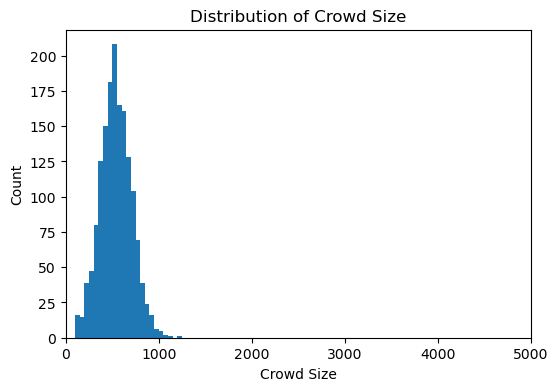

In [48]:
plt.figure(figsize=(6,4))
plt.hist(vol_eda["Crowd_Size"], bins=1000)
plt.xlabel("Crowd Size")
plt.xlim(0,5000)
plt.ylabel("Count")
plt.title("Distribution of Crowd Size")
plt.show()

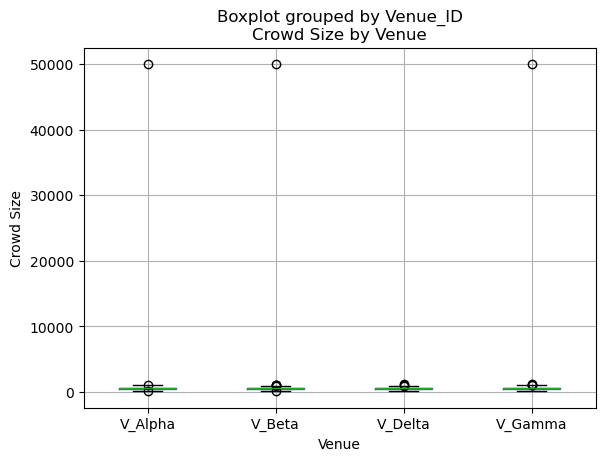

In [20]:
crowd_eda.boxplot(column="Crowd_Size", by="Venue_ID")
plt.title("Crowd Size by Venue")
plt.xlabel("Venue")
plt.ylabel("Crowd Size")
plt.show()

In [23]:
 crowd_eda["Crowd_Size"].corr(crowd_eda["Crowd_Energy"])

np.float64(0.006691658752154837)

### So we should remove outliers for Crowd_size

## Checking Ticket Price

In [24]:
price_eda = df.copy()

In [26]:
price_eda["Ticket_Price"].describe()

count     1844
unique    1608
top       Free
freq        47
Name: Ticket_Price, dtype: object

## So, We need to do clean the prices

In [41]:
df["Opener_Rating"].describe()

count    1844.000000
mean        3.028742
std         1.406418
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: Opener_Rating, dtype: float64

### No anamolies in Opener_Rating

In [49]:
df["Day_of_Week"].describe()

count    1844.000000
mean        3.020607
std         2.023896
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max         6.000000
Name: Day_of_Week, dtype: float64